# Function Testing

In [477]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import scipy
import matplotlib
from importlib import reload
import gsw
from cmocean import cm as cmo 

In [2]:
import funcs
import filt_funcs as ff
reload(funcs)
reload(ff)

<module 'filt_funcs' from '/home.ufs/amf2288/argo-intern/filt_funcs.py'>

## Load aselect example data

In [119]:
#glider data
ds_660_grid = xr.open_dataset('ctd_660_vert_4m_binned_29_june_2021.nc')
gselect=ds_660_grid.sel(dives=slice(50,450),ctd_pressure=slice(200,900))

#argo box
box=xr.open_dataset("202206/202206_lon:(30,40)_lat:(-55,-50).nc")
aselect=ff.get_ds_interp(box,0,2000,4)

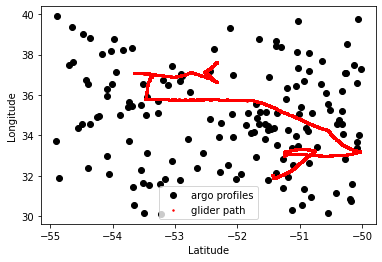

In [120]:
plt.scatter(aselect.LATITUDE,aselect.LONGITUDE,color='black',label='argo profiles')
plt.scatter(gselect.latitude,gselect.longitude,color='r',s=2,label='glider path')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

In [124]:
aselect['SPICE'] = gsw.spiciness0(aselect.SA,aselect.CT).rename('SPICE')

## Dhruv's filtering method

In [5]:
dx = (aselect.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=1)-aselect.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=0)).values
N = len(aselect.PRES_INTERPOLATED) +1
lfilter = 50*dx
sigmafilter = lfilter/np.sqrt(12)

nfilter_hat = lfilter/dx 
nfilter_gauss = sigmafilter/dx

f_hat = funcs.top_hat_kernel(nfilter_hat, N/2-1)
f_gauss = funcs.gaussian_kernel(nfilter_gauss, N/2-1)

In [6]:
f1 = aselect.TEMP.isel(N_PROF=0)
f1_num = int(f1.N_PROF_NEW)

f1_hat = funcs.my_filter1d(f1.values, nfilter_hat, funcs.top_hat_kernel, mode='wrap')
f1_gauss = funcs.my_filter1d(f1.values, nfilter_gauss, funcs.gaussian_kernel, mode='wrap')

f2 = aselect.TEMP.isel(N_PROF=120)
f2_num = int(f2.N_PROF_NEW)

f2_hat = funcs.my_filter1d(f2.values, nfilter_hat, funcs.top_hat_kernel, mode='wrap')
f2_gauss = funcs.my_filter1d(f2.values, nfilter_gauss, funcs.gaussian_kernel, mode='wrap')

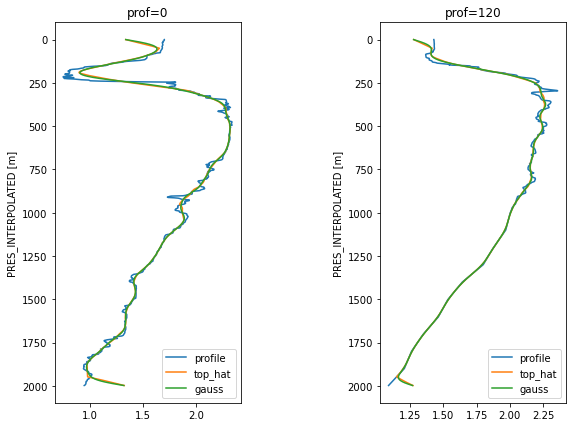

In [7]:
plt.figure(figsize=(15,7))
x=aselect.PRES_INTERPOLATED

plt.subplot(1,3,1)
plt.plot(f1, x, label='profile')
plt.plot(f1_hat, x, label='top_hat')
plt.plot(f1_gauss, x, label='gauss')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.title("prof={}".format(f1_num))
plt.legend()

plt.subplot(1,3,2)
plt.plot(f2, x, label='profile')
plt.plot(f2_hat, x, label='top_hat')
plt.plot(f2_gauss, x, label='gauss')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.title("prof={}".format(f2_num))
plt.legend()

plt.subplots_adjust(wspace=0.75)

## Filtering Functions

#### Create Mask

In [8]:
def get_mask(ds, scale, dim2='PRES_INTERPOLATED', bound=False):
    
    if bound==False:
        mask = np.ones((len(ds[dim2])))
        
    if bound==True:
        start = ds[dim2].isel({dim2:0}).values + (scale-1)
        end = ds[dim2].isel({dim2:-1}) - (scale-1)
        mask = ds[dim2].where(ds[dim2]>start).where(ds[dim2]<end).values
        
        mask[np.greater(mask,0)] = 1
        mask[np.isnan(mask)] = 0
    
    return mask

#### Create filter scales

In [9]:
def get_lfilters(first, last, num, log=False):
    
    if log==False:
        lfilters = np.linspace(first, last, num)
        
    if log==True:
        first_exp = np.log10(first)
        last_exp = np.log10(last)
        lfilters = np.logspace(first_exp, last_exp, num)
        
    return lfilters

In [10]:
def get_nfilter(ds, lfilter, dim2='PRES_INTERPOLATED'):
    
    dx = (ds[dim2].isel({dim2:1})-ds[dim2].isel({dim2:0})).values
    sigmafilter = lfilter/np.sqrt(12)
    nfilter = sigmafilter/dx
    
    return nfilter

#### Filter at one scale

In [11]:
def get_filt_prof(prof, lfilter, variable='TEMP', dim1='N_PROF', dim2='PRES_INTERPOLATED', bound=True):
    
    mask = get_mask(prof, lfilter, dim2=dim2, bound=bound)
    
    nfilter = get_nfilter(prof, lfilter, dim2=dim2)
    
    prof_filt = filter.gaussian_filter1d(prof, sigma=nfilter, mode='wrap')
    
    return prof_filt

In [12]:
def get_filt_single(ds, lfilter, variable='TEMP', dim1='N_PROF', dim2='PRES_INTERPOLATED', bound=False):
    
    mask = get_mask(ds, lfilter, dim2=dim2, bound=bound)
    
    nfilter = get_nfilter(ds, lfilter, dim2=dim2)
    
    temp = np.zeros((ds[dim1].shape[0], ds[dim2].shape[0]))
    temp[:,:] = filter.gaussian_filter1d(ds[variable], sigma=nfilter, mode='wrap')
    
    ds_filt = xr.DataArray(temp, dims=['N_PROF', 'PRES_INTERPOLATED'], coords={'N_PROF':ds[dim1], 'PRES_INTERPOLATED':ds[dim2]})
    
    number=np.arange(0,len(ds_filt.N_PROF))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds[dim1].dims)
    ds_filt['MASK']=xr.DataArray(mask,dims=ds_filt[dim2].dims)
    
    return ds_filt

In [13]:
single_filt = get_filt_single(aselect, 100, bound=True)

#### Filter at multiple scales

In [51]:
def get_filt_multi(ds, first, last, num, variable='TEMP', dim1='N_PROF', dim2='PRES_INTERPOLATED', bound=False, log=False):
    
    lfilters = get_lfilters(first=first, last=last, num=num, log=log)
    mask = get_mask(ds, last, dim2=dim2, bound=bound)
    
    temp=np.zeros((ds[dim1].shape[0],ds[dim2].shape[0],num))
    for n in range(0,num):
        temp[:,:,n] = get_filt_single(ds=ds, lfilter=lfilters[n], variable=variable, dim1=dim1, dim2=dim2, bound=bound)
    
    ds_filt = xr.DataArray(temp, dims=['N_PROF', 'PRES_INTERPOLATED', 'FILT_SCALE'], 
                           coords={'N_PROF':ds[dim1], 'PRES_INTERPOLATED':ds[dim2], 'FILT_SCALE':lfilters})
    
    number=np.arange(0,len(ds[dim1]))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds[dim1].dims)
    ds_filt['MASK']=xr.DataArray(mask,dims=ds[dim2].dims)
    
    return ds_filt

In [42]:
multi_lin_False = get_filt_multi(aselect, 10,500,50)
multi_log_False = get_filt_multi(aselect, 10,500,50, log=True)

multi_lin_True = get_filt_multi(aselect, 10,500,50, bound=True)
multi_log_True = get_filt_multi(aselect, 10,500,50, bound=True, log=True)

## Compare Dhruv's functions to mine

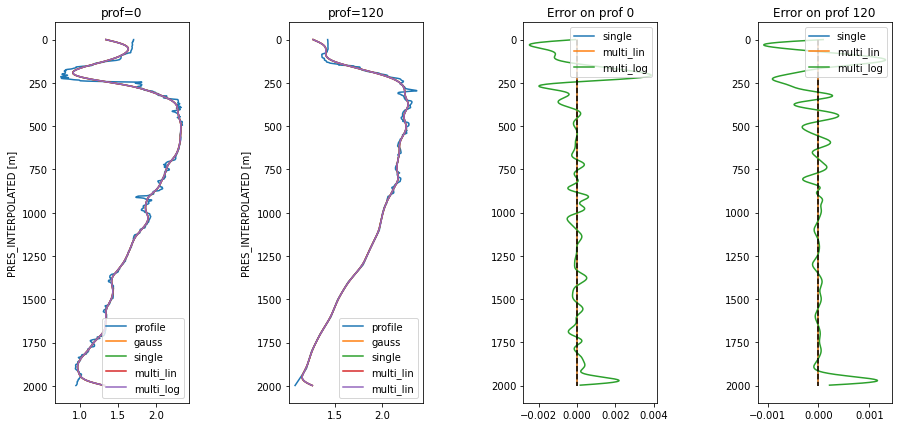

In [43]:
plt.figure(figsize=(15,7))
x=aselect.PRES_INTERPOLATED

plt.subplot(1,4,1)
plt.plot(f1, x, label='profile')
plt.plot(f1_gauss, x, label='gauss')
plt.plot(single_filt.isel(N_PROF=f1_num), x, label='single')
plt.plot(multi_lin_False.isel(N_PROF=f1_num).sel(FILT_SCALE=100.), x, label='multi_lin')
plt.plot(multi_log_False.isel(N_PROF=f1_num).isel(FILT_SCALE=29), x, label='multi_log')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.title("prof={}".format(f1_num))
plt.legend()

plt.subplot(1,4,2)
plt.plot(f2, x, label='profile')
plt.plot(f2_gauss, x, label='gauss')
plt.plot(single_filt.isel(N_PROF=f2_num), x, label='single')
plt.plot(multi_lin_False.isel(N_PROF=f2_num).sel(FILT_SCALE=100.), x, label='multi_lin')
plt.plot(multi_log_False.isel(N_PROF=f2_num).isel(FILT_SCALE=29), x, label='multi_lin')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.title("prof={}".format(f2_num))
plt.legend()

plt.subplot(1,4,3)
plt.plot(single_filt.isel(N_PROF=f1_num)-f1_gauss, aselect.PRES_INTERPOLATED, label='single')
plt.plot(multi_lin_False.isel(N_PROF=f1_num).sel(FILT_SCALE=100.)-f1_gauss, aselect.PRES_INTERPOLATED, label='multi_lin')
plt.plot(multi_log_False.isel(N_PROF=f1_num).isel(FILT_SCALE=29)-f1_gauss, aselect.PRES_INTERPOLATED, label='multi_log')
plt.vlines(0,0,2000, linestyles='dashed', color='black')
plt.gca().invert_yaxis()
plt.title("Error on prof {}".format(f1_num))
plt.legend()

plt.subplot(1,4,4)
plt.plot(single_filt.isel(N_PROF=f2_num)-f2_gauss, aselect.PRES_INTERPOLATED, label='single')
plt.plot(multi_lin_False.isel(N_PROF=f2_num).sel(FILT_SCALE=100.)-f2_gauss, aselect.PRES_INTERPOLATED, label='multi_lin')
plt.plot(multi_log_False.isel(N_PROF=f2_num).isel(FILT_SCALE=29)-f2_gauss, aselect.PRES_INTERPOLATED, label='multi_log')
plt.vlines(0,0,2000, linestyles='dashed', color='black')
plt.gca().invert_yaxis()
plt.title("Error on prof {}".format(f2_num))
plt.legend()

plt.subplots_adjust(wspace=0.75)

Text(0.5, 1.0, 'multi_log')

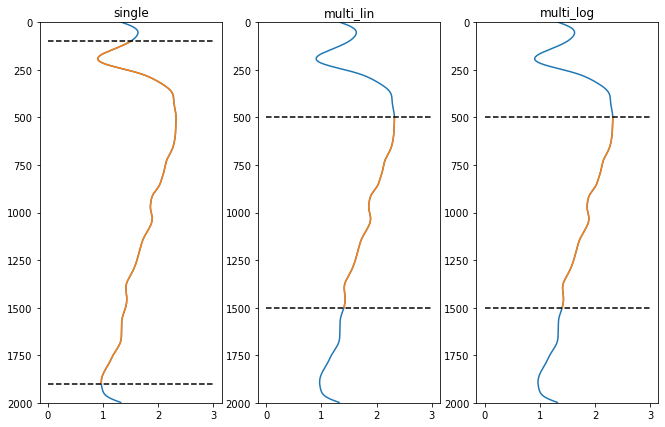

In [58]:
plt.figure(figsize=(15,7))
x=aselect.PRES_INTERPOLATED

plt.subplot(1,4,1)
plt.plot(single_filt.isel(N_PROF=f1_num),x)
plt.plot(single_filt.isel(N_PROF=f1_num).where(single_filt.MASK==1),x)
plt.hlines(100,0,3,linestyles='dashed',color='black')
plt.hlines(1900,0,3,linestyles='dashed',color='black')
plt.ylim(0,2000)
plt.gca().invert_yaxis()
plt.title('single')

plt.subplot(1,4,2)
plt.plot(multi_lin_False.isel(N_PROF=f1_num).sel(FILT_SCALE=100.),x)
plt.plot(multi_lin_True.isel(N_PROF=f1_num).isel(FILT_SCALE=9).where(multi_lin_True.MASK==1),x)
plt.hlines(500,0,3,linestyles='dashed',color='black')
plt.hlines(1500,0,3,linestyles='dashed',color='black')
plt.ylim(0,2000)
plt.gca().invert_yaxis()
plt.title('multi_lin')

plt.subplot(1,4,3)
plt.plot(multi_log_False.isel(N_PROF=f1_num).isel(FILT_SCALE=29),x)
plt.plot(multi_log_True.isel(N_PROF=f1_num).isel(FILT_SCALE=29).where(multi_lin_True.MASK==1),x)
plt.hlines(500,0,3,linestyles='dashed',color='black')
plt.hlines(1500,0,3,linestyles='dashed',color='black')
plt.ylim(0,2000)
plt.gca().invert_yaxis()
plt.title('multi_log')

# EV Functions

In [109]:
import filt_funcs as ff
import EV_funcs as ef

In [ ]:
xr.transpose() #can change order of dimensions, do this before inputting to function

In [106]:
def get_filt_squared(ds, lfilter, variable='TEMP', dim1='N_PROF', dim2='PRES_INTERPOLATED'):
    
    ds_filt = ff.get_filt_single(ds, lfilter, variable=variable, dim1=dim1, dim2=dim2)
    ds_filt_squared = ds_filt**2
    
    return ds_filt_squared

In [107]:
def get_squared_filt(ds, lfilter, variable='TEMP', dim1='N_PROF', dim2='PRES_INTERPOLATED'):
    
    ds_squared = ds[[variable]]**2
    ds_squared_filt = ff.get_filt_single(ds_squared, lfilter, variable=variable, dim1=dim1, dim2=dim2)
    
    return ds_squared_filt

In [108]:
def get_EKE(ds, lfilter, variable='TEMP', dim1='N_PROF', dim2='PRES_INTERPOLATED'):
    
    ds_filt_squared = get_filt_squared(ds, lfilter, variable=variable, dim1=dim1, dim2=dim2)
    ds_squared_filt = get_squared_filt(ds, lfilter, variable=variable, dim1=dim1, dim2=dim2)
    ds_EKE = ds_squared_filt - ds_filt_squared
    
    return ds_EKE

In [96]:
aselect_TEMP_EKE = get_EKE(aselect, 100)
aselect_PSAL_EKE = get_EKE(aselect, 100, variable='PSAL')

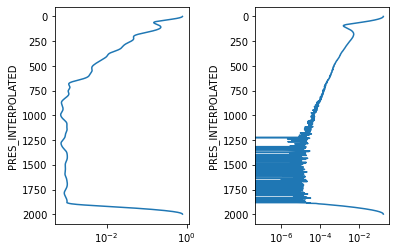

In [101]:
plt.subplot(1,2,1)
aselect_TEMP_EKE.mean("N_PROF").plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')

plt.subplot(1,2,2)
aselect_PSAL_EKE.mean("N_PROF").plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')

plt.subplots_adjust(wspace=0.5)

In [103]:
aselect_T_test = ef.get_EKE(aselect, 100)
aselect_P_test = ef.get_EKE(aselect, 100, variable='PSAL')

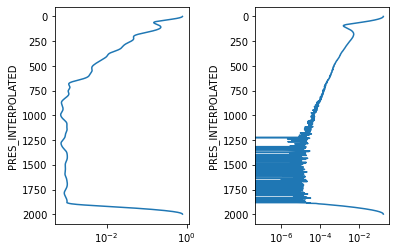

In [104]:
plt.subplot(1,2,1)
aselect_T_test.mean("N_PROF").plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')

plt.subplot(1,2,2)
aselect_P_test.mean("N_PROF").plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')

plt.subplots_adjust(wspace=0.5)

In [114]:
def get_NEV(ds,ds_EV,variable,coarsen_scale=40):
    
    return ((ds_EV.mean('N_PROF')/ get_drho_dz(ds, variable=variable, coarsen_scale=coarsen_scale).mean('N_PROF')**2)**(1/2))

In [115]:
def get_drho_dz (ds, variable, coarsen_scale=5):
    coarsened_rho = ds[variable].coarsen(PRES_INTERPOLATED=coarsen_scale).mean()
    
    drho_dz_coarsened = coarsened_rho.diff('PRES_INTERPOLATED')/(2*coarsen_scale)
    
    drho_dz = drho_dz_coarsened.interp(PRES_INTERPOLATED=ds.PRES_INTERPOLATED)
    
    return drho_dz

# Box loader function

Want this function to:
- load points based on given lat/lon and depth range
- convert to xarray
- convert points to profile
- interpolate pressures
- add spice
- map box

In [117]:
def get_box(box,sample_min):
    ds=argo_loader.region(box)
    print('loading points complete')
    
    ds=ds.to_xarray()
    print('to xarray complete')
    
    ds=ds.argo.teos10(['CT','SA','SIG0'])
    ds=ds.argo.point2profile()
    print('point to profile complete')
    
    ds_interp=ff.get_ds_interp(ds,0,2000,sample_min)
    print('interpolation complete')
    
    ds_interp['SPICE'] = gsw.spiciness0(ds_interp.SA,ds_interp.CT).rename('SPICE')
    print('adding spice complete')
        
    return ds_interp

# CCS Poster Plotting Functions

In [404]:
import EV_funcs as ef
reload(ef)

<module 'EV_funcs' from '/home.ufs/amf2288/argo-intern/EV_funcs.py'>

In [461]:
import plot_funcs as pf
reload(pf)

<module 'plot_funcs' from '/home.ufs/amf2288/argo-intern/plot_funcs.py'>

In [405]:
s_ds=xr.open_dataset("202206/202206_lon:(25,45)_lat:(-60,-50).nc")
s = ff.get_ds_interp(s_ds,0,2000,4)
s['SPICE'] = gsw.spiciness0(s.SA,s.CT).rename('SPICE')

In [406]:
def mult_mean(ds_li, variable, dim1='N_PROF'):
    mean_li=[]
    
    for n in range(0,len(ds_li)):
        mean = ds_li[n][variable].mean({dim1})
        mean_li.append(mean)
        
    return mean_li

def mult_EV(ds_li, lfilter, variable, dim1='N_PROF', dim2='PRES_INTERPOLATED',bound=True):
    EV_li = []
    
    for n in range(0,len(ds_li)):
        EV = ef.get_EV(ds=ds_li[n],lfilter=lfilter,variable=variable,dim1=dim1,dim2=dim2,bound=bound)
        EV_li.append(EV)
        
    return EV_li

def mult_NEV(ds_li, ds_EV_li, variable, dim1='N_PROF', dim2='PRES_INTERPOLATED', coarsen_scale=40):
    NEV_li=[]
    
    for n in range(0,len(ds_li)):
        NEV=ef.get_NEV(ds=ds_li[n], ds_EV=ds_EV_li[n], variable=variable, dim1=dim1, dim2=dim2, coarsen_scale=coarsen_scale)
        NEV_li.append(NEV)
    
    return NEV_li

In [468]:
def plot_quad(ds_li, dim1='N_PROF_NEW', dim2='PRES_INTERPOLATED', labels=None, bound=True):
    
    density_mean_li = mult_mean(ds_li,variable='SIG0')
    density_EV_li = mult_EV(ds_li,100,variable='SIG0',bound=bound)
    density_NEV_li = mult_NEV(ds_li,density_EV_li,variable='SIG0')

    spice_mean_li = mult_mean(ds_li,variable='SPICE')
    spice_EV_li = mult_EV(ds_li,100,variable='SPICE',bound=bound)
    
    plt.figure(figsize=(9,7))

    plt.subplot(1,4,1)
    for n in range(0,len(density_mean_li)):
        density_mean_li[n].plot(y=dim2,label=labels[n])
    plt.ylim(-50,2050)
    plt.ylabel('Pressure(dbar)')
    plt.xlabel('Density (kg/m^3)')
    plt.grid(axis='y')
    plt.gca().invert_yaxis()
    plt.title('Mean Pot. Density')

    plt.subplot(1,4,2)
    for n in range(0,len(density_NEV_li)):
        density_NEV_li[n].where(density_NEV_li[n].MASK==1).plot(y=dim2,label=labels[n])
    plt.ylim(-50,2050)
    plt.ylabel('')
    plt.yticks(labels=[],ticks=(np.arange(0,2001,250)))
    plt.xlabel('Isopycnal Displacement (m)')
    plt.xscale('log')
    plt.grid(axis='y')    
    plt.gca().invert_yaxis()
    plt.title('Norm. Var. of Density')

    plt.subplot(1,4,3)
    for n in range(0,len(spice_mean_li)):
        spice_mean_li[n].plot(y=dim2,label=labels[n])
    plt.ylim(-50,2050)
    plt.ylabel('')
    plt.yticks(labels=[],ticks=(np.arange(0,2001,250)))
    plt.xlabel('Spice (kg/m^3)')
    plt.grid(axis='y')
    plt.gca().invert_yaxis()
    plt.title('Mean Spice')

    plt.subplot(1,4,4)
    for n in range(0,len(spice_EV_li)):
        spice_EV_li[n].where(spice_EV_li[n].MASK==1).plot(y=dim2,label=labels[n])
    plt.ylim(-50,2050)
    plt.ylabel('')
    plt.yticks(labels=[],ticks=(np.arange(0,2001,250)))
    plt.xlabel('Variance of Spice (m^2)')
    plt.xscale('log')
    plt.grid(axis='y')    
    plt.gca().invert_yaxis()
    plt.title('Eddy Var. of Spice')
    
    plt.legend(bbox_to_anchor=(2.3, 0.55))
    
    plt.subplots_adjust(wspace=0.3, hspace=0.25)

In [469]:
sm1 = s.where(s.TIME.dt.month>0).where(s.TIME.dt.month<4)
sm2 = s.where(s.TIME.dt.month>3).where(s.TIME.dt.month<7)
sm3 = s.where(s.TIME.dt.month>6).where(s.TIME.dt.month<10)
sm4 = s.where(s.TIME.dt.month>9).where(s.TIME.dt.month<13)

mlabels=['Jan,Feb,Mar','Apr,May,Jun','Jul,Aug,Sep','Oct,Nov,Dec']
sm_li=[sm1,sm2,sm3,sm4]

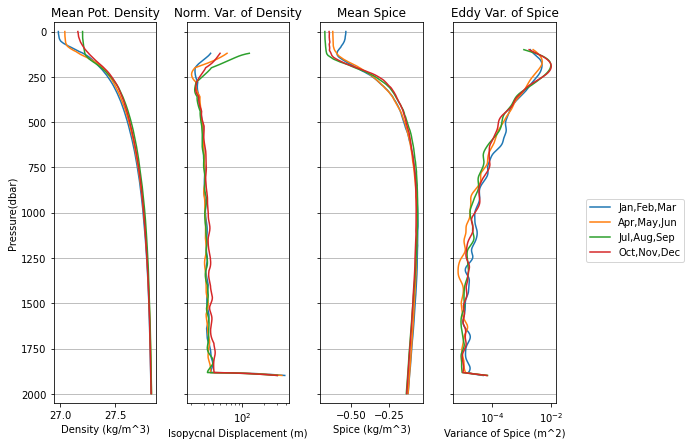

In [470]:
plot_quad(sm_li,labels=mlabels)

In [410]:
sy1 = s.where(s.TIME.dt.year>2008).where(s.TIME.dt.year<2014)
sy2 = s.where(s.TIME.dt.year>2013).where(s.TIME.dt.year<2020)
sy3 = s.where(s.TIME.dt.year>2019).where(s.TIME.dt.year<2023)

ylabels=['2009-2012','2015-2019','2020-2023']
sy_li=[sy1,sy2,sy3]

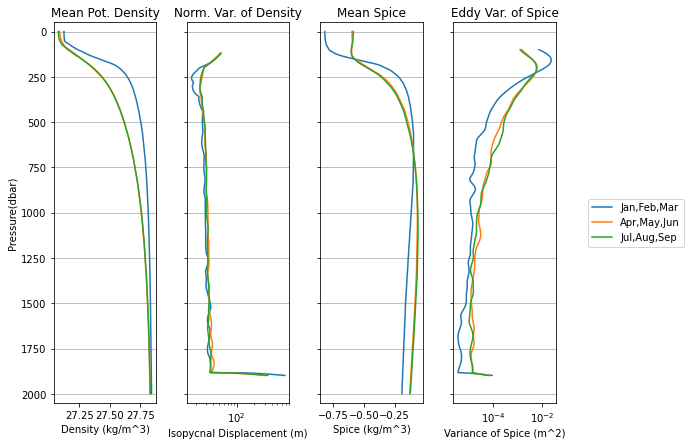

In [411]:
plot_quad(sy_li,labels=labels)

In [420]:
def postobox(lon, lat):
    y_box = [lat[0], lat[0], lat[1], lat[1], lat[0]]
    x_box = [lon[0], lon[1], lon[1], lon[0], lon[0]]
    
    return x_box, y_box

In [437]:
def plot_map(box_li,stats='binned_stats.nc'):
    
    # visualization
    import matplotlib.colors as colors
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from matplotlib.ticker import MaxNLocator
    import cartopy.crs as ccrs
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    import cartopy.feature as cfeature
    import cmocean
    
    ds_stats = xr.open_dataset(stats)

    x_c = ds_stats.lon
    y_c = ds_stats.lat
    # get 1st and 99th percentiles of values to plot to get a useful range for the colorscale
    EKE= ds_stats.EKE
    v1,v2 = np.nanpercentile(EKE.T,[1,99])

    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=0))
    cmap = cmocean.cm.matter_r
    pcm = ax.pcolormesh(x_c, y_c, 
                        EKE, 
                        cmap=cmap, 
                        transform=ccrs.PlateCarree(),
                        vmin=v1, vmax=v2/2)

    # gridlines and labels
    gl = ax.gridlines(color='k', linewidth=0.1, linestyle='-',
                      xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30),
                      draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

    #plt.plot(postobox(lon, lat), color='red')
    for n in range(0,len(box_li)):
        ax.plot(postobox(box_li[n][:2],box_li[n][2:])[0],postobox(box_li[n][:2], box_li[n][2:])[1], color='black',transform=ccrs.PlateCarree(),lw=2)

    # add land and coastline
    ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05, axes_class=plt.Axes)
    cb = fig.colorbar(pcm, cax=cax);
    cb.ax.set_ylabel(r'EKE [$m^2/s^2$]');

In [438]:
np_param=[-155,-145,30,35,0,2000]
na_param=[-55,-45,40,45,0,2000]
so_param=[30,40,-55,-50,0,2000]
io_param=[90,100,-15,-10,0,2000]

boxes_li=[np_param,na_param,so_param,io_param]

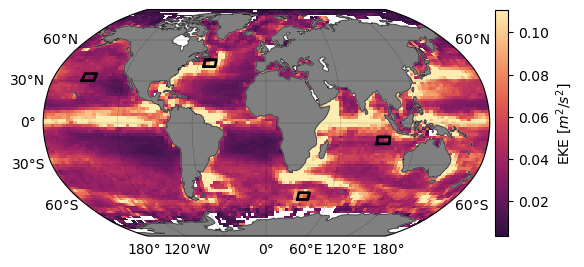

In [439]:
plot_map(boxes_li)

In [440]:
s_param = [25,45,-60,-50]
box_li = [s_param]

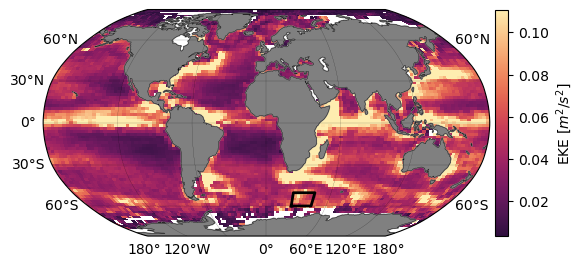

In [441]:
plot_map(box_li)

In [442]:
def TS_grids(Taxis, Saxis):
    Taxis = numpy.linspace(Taxis[0],Taxis[1],Taxis[2])
    Saxis = numpy.linspace(Saxis[0],Saxis[1],Saxis[2])
    Tgrid, Sgrid = np.meshgrid(Taxis, Saxis)
    
    return Tgrid, Sgrid

In [443]:
def rhospice_grids(Tgrid, Sgrid):
    rho_grid = gsw.rho(Sgrid, Tgrid, 0)
    spice_grid = gsw.spiciness0(Sgrid, Tgrid)
    
    return rho_grid, spice_grid

In [453]:
def plot_TS(ds_li, Taxis, Saxis, variable1='CT', variable2='SA'):
    Tgrid, Sgrid = TS_grids(Taxis=Taxis, Saxis=Saxis)
    rho_grid, spice_grid = rhospice_grids(Tgrid, Sgrid)
    
    colors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
    
    for n in range(0,len(ds_li)):
        plt.plot(ds_li[n][variable2],ds_li[n][variable1],'.',markersize=0.5,color=colors[n])
        
    contour_rho = plt.contour(Sgrid,Tgrid,rho_grid,colors='k')
    plt.clabel(contour_rho)
    contour_spice = plt.contour(Sgrid,Tgrid,spice_grid,colors='r')
    plt.clabel(contour_spice)
    
    plt.ylabel('Temperature (°C)')
    plt.xlabel('Salinity (g/kg)')

In [458]:
Taxis=[-2,6,50]
Saxis=[33.5,35.25,51]

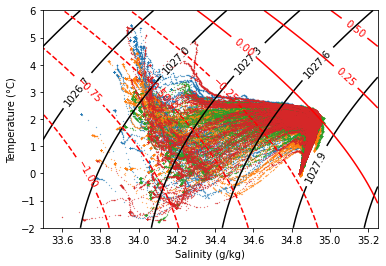

In [459]:
plot_TS(sm_li,Taxis,Saxis)

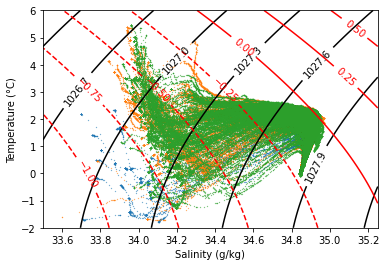

In [460]:
plot_TS(sy_li,Taxis,Saxis)

# Glider Paper Plotting Functions

In [472]:
import scipy.interpolate as interpolate

def func_var_int(ds, var, rho_grid, dim1='N_PROF_NEW', dim2='PRES_INTERPOLATED', flag='group'):
    
    N_PROF_num = ds[dim1].values
    
    rho = ds.SIG0
    rho_nonan = rho.where(~np.isnan(rho), drop=True)
    
    var_nonan = ds[var].where(~np.isnan(rho), drop=True)
    
    var_nonan2 = var_nonan.where(~np.isnan(var_nonan), drop=True)
    
    if flag == 'group': # incase density is identical b/w two points (this makes things very slow)
        var_nonan = var_nonan.groupby(rho_nonan).mean()
        rho_nonan = rho_nonan.groupby(rho_nonan).mean()
    
    if (len(rho_nonan)>2) & (len(var_nonan2)>2):
        fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    
        var_tilde = fvar(rho_grid)
    else:
        var_tilde = np.nan*rho_grid
    
    return xr.DataArray(var_tilde.reshape((-1,1)),
                        dims = ['rho_grid', dim1],
                        coords = {'rho_grid': rho_grid, dim1: [N_PROF_num]}).rename(var)

In [473]:
def interpolate2density(ds_z, rho_grid, dim1='N_PROF_NEW', dim2='PRES_INTERPOLATED'):
    
    N_PROF_ind = 0
    pres_tilde_xr  = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), dim2,rho_grid)
    CT_tilde_xr    = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'CT',rho_grid)
    SA_tilde_xr    = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SA', rho_grid)
    SIG0_tilde_xr  = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SIG0', rho_grid)
    SPICE_tilde_xr = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SPICE', rho_grid)

    for N_PROF_ind in range(1, len(ds_z.N_PROF)):
        if np.mod(N_PROF_ind, 50)==0:
            print(N_PROF_ind)
        pres_tilde_xr  = xr.concat([pres_tilde_xr , func_var_int(ds_z.isel(N_PROF=N_PROF_ind), dim2, rho_grid)], dim=dim1)
        CT_tilde_xr    = xr.concat([CT_tilde_xr , func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'CT', rho_grid)], dim=dim1)
        SA_tilde_xr    = xr.concat([SA_tilde_xr , func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SA', rho_grid)], dim=dim1)
        SIG0_tilde_xr  = xr.concat([SIG0_tilde_xr , func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SIG0', rho_grid)], dim=dim1)
        SPICE_tilde_xr = xr.concat([SPICE_tilde_xr , func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SPICE', rho_grid)], dim=dim1)
    

    ds_rho = xr.merge([pres_tilde_xr, CT_tilde_xr,
                             SA_tilde_xr, SIG0_tilde_xr, SPICE_tilde_xr])
    
    return ds_rho

In [474]:
rho_grid = np.linspace(26.5, 28,1001)
s_rho = interpolate2density(s, rho_grid)

50
100
150
200
250
300


In [475]:
s_rho

<xarray.Dataset>
Dimensions:            (rho_grid: 1001, N_PROF_NEW: 335)
Coordinates:
  * rho_grid           (rho_grid) float64 26.5 26.5 26.5 26.5 ... 28.0 28.0 28.0
  * N_PROF_NEW         (N_PROF_NEW) int64 0 1 2 3 4 5 ... 330 331 332 333 334
Data variables:
    PRES_INTERPOLATED  (rho_grid, N_PROF_NEW) float64 nan nan nan ... nan nan
    CT                 (rho_grid, N_PROF_NEW) float64 nan nan nan ... nan nan
    SA                 (rho_grid, N_PROF_NEW) float64 nan nan nan ... nan nan
    SIG0               (rho_grid, N_PROF_NEW) float64 nan nan nan ... nan nan
    SPICE              (rho_grid, N_PROF_NEW) float64 nan nan nan ... nan nan

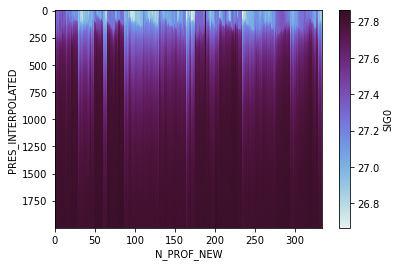

In [479]:
s.SIG0.plot(y='PRES_INTERPOLATED',x='N_PROF_NEW',cmap=cmo.dense)
plt.gca().invert_yaxis()

In [506]:
def plot_depth_profs(ds_z, ds_rho, variable1='CT', variable2='SIG0', dim1='N_PROF_NEW', dim2='PRES_INTERPOLATED', dim3='rho_grid'):
    
    levels = np.linspace(ds_z[variable2].min(), ds_z[variable2].max(), 7)
    
    plt.figure(figsize=(10,12))
    
    plt.subplot(4,1,1)
    ds_z[variable2].plot(y=dim2, x=dim1, cmap=cmo.dense, rasterized=True)
    ds_z[variable2].plot.contour(y=dim2, x=dim1, levels=levels, colors='w', linewidths=0.5)
    plt.gca().invert_yaxis()
    plt.ylabel(dim2)
    plt.xlabel(dim1)
    plt.title('DEPTH SPACE: Density with Density Contours')
        
    plt.subplot(4,1,2)
    ds_z[variable1].plot(y=dim2,x=dim1, cmap=cmo.thermal, rasterized=True, cbar_kwargs={'label': 'Temperature [$^o$C]'})
    ds_z[variable2].plot.contour(y=dim2,x=dim1,levels=levels, colors='b', linewidths=0.5)
    plt.gca().invert_yaxis()
    plt.ylabel(dim2)
    plt.xlabel(dim1)
    plt.title('DEPTH SPACE: Temperature with Density Contours')
        
    plt.subplot(4,1,3)
    ds_rho[variable1].plot(y=dim3, x=dim1, cmap=cmo.thermal, rasterized=True, cbar_kwargs={'label': 'Temperature [$^o$C]'})
    plt.hlines(levels, ds_z.N_PROF_NEW.values.min(), ds_z.N_PROF_NEW.values.max(), linewidths=0.5, colors='b')
    plt.ylim(ds_z[variable2].min(), ds_z[variable2].max())
    plt.gca().invert_yaxis()
    plt.ylabel(dim2)
    plt.xlabel(dim1)
    plt.title('DENSITY SPACE: Temperature with Density Contours')
    
    plt.subplot(4,1,4)
    #this will be spice anomaly
    plt.title('ISOPYCNAL DEPTH: Spice Anomaly with Density Contours')
    
    plt.subplots_adjust(hspace=0.5)

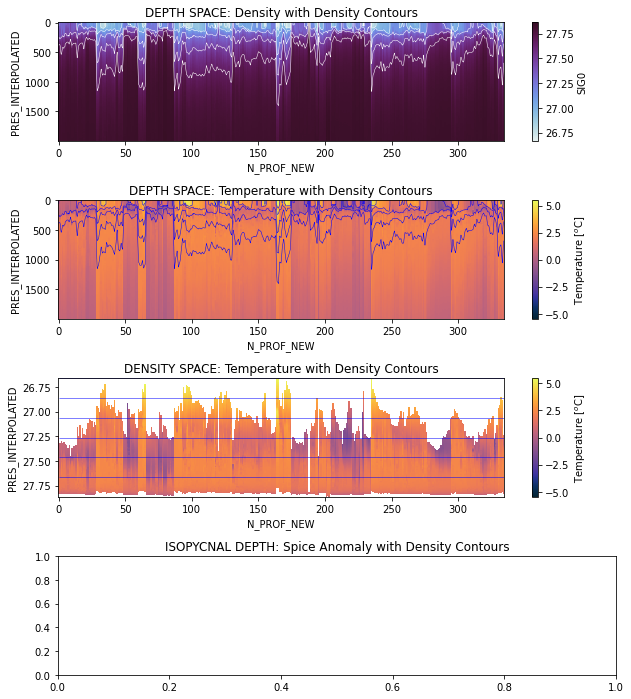

In [507]:
plot_depth_profs(s,s_rho)